In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style
import os
from pathlib import Path

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

## Part1 : Question 1

**Data loading**

We work with the Ninapro DB1 data stored in the project folder:

- Root: `Data/s2/S2_A1_E1/`
- File: `S2_A1_E1.mat`

In this question we only need **subject 2** and **exercise S2\_A1\_E1**, which are already selected in this file.

In [43]:
# --- Paths ---
current_dir = os.getcwd()
mat_path = os.path.join(current_dir, "Data", "S2", "S2_A1_E1")

data = loadmat(mat_path, squeeze_me=True)
list(data.keys())

['__header__',
 '__version__',
 '__globals__',
 'subject',
 'exercise',
 'stimulus',
 'emg',
 'glove',
 'restimulus',
 'repetition',
 'rerepetition']

From the `.mat` file we extract:

- `emg` : EMG envelope (already RMS-processed and band-pass filtered by the Otto Bock electrodes).
- `restimulus` : **relabelled** movement labels (after GLR-based relabelling in the Ninapro pipeline).
- `rerepetition` : **relabelled** repetition index.

We also read `subject` and `exercise` to double-check we are using the correct data.
Sampling frequency is fixed to **100 Hz** as described in the paper.

In [44]:
# Convert to numpy arrays with convenient shapes
emg = np.asarray(data["emg"], dtype=float)              # [T x n_channels]
restimulus = np.asarray(data["restimulus"]).ravel()     # [T]
rerepetition = np.asarray(data["rerepetition"]).ravel() # [T]

subject_id = int(np.asarray(data["subject"]).ravel()[0])
exercise_id = data["exercise"]

print(f"Subject ID: {subject_id}")
print(f"Exercise: {exercise_id}")
print(f"EMG shape: {emg.shape}")
print(f"Unique restimulus labels: {np.unique(restimulus)}")
print(f"Unique rerepetition labels: {np.unique(rerepetition)}")

# Sampling frequency according to Ninapro DB1 description
fs = 100  # Hz
n_samples, n_channels = emg.shape

Subject ID: 2
Exercise: 1
EMG shape: (100686, 10)
Unique restimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique rerepetition labels: [ 0  1  2  3  4  5  6  7  8  9 10]


**First visual inspection (raw EMG envelope)**

Before any processing, we plot a short segment of the EMG envelope for all channels, and the corresponding relabelled stimulus (`restimulus`).  
This helps to check whether the signals look reasonable and whether the labels are consistent with the activity.

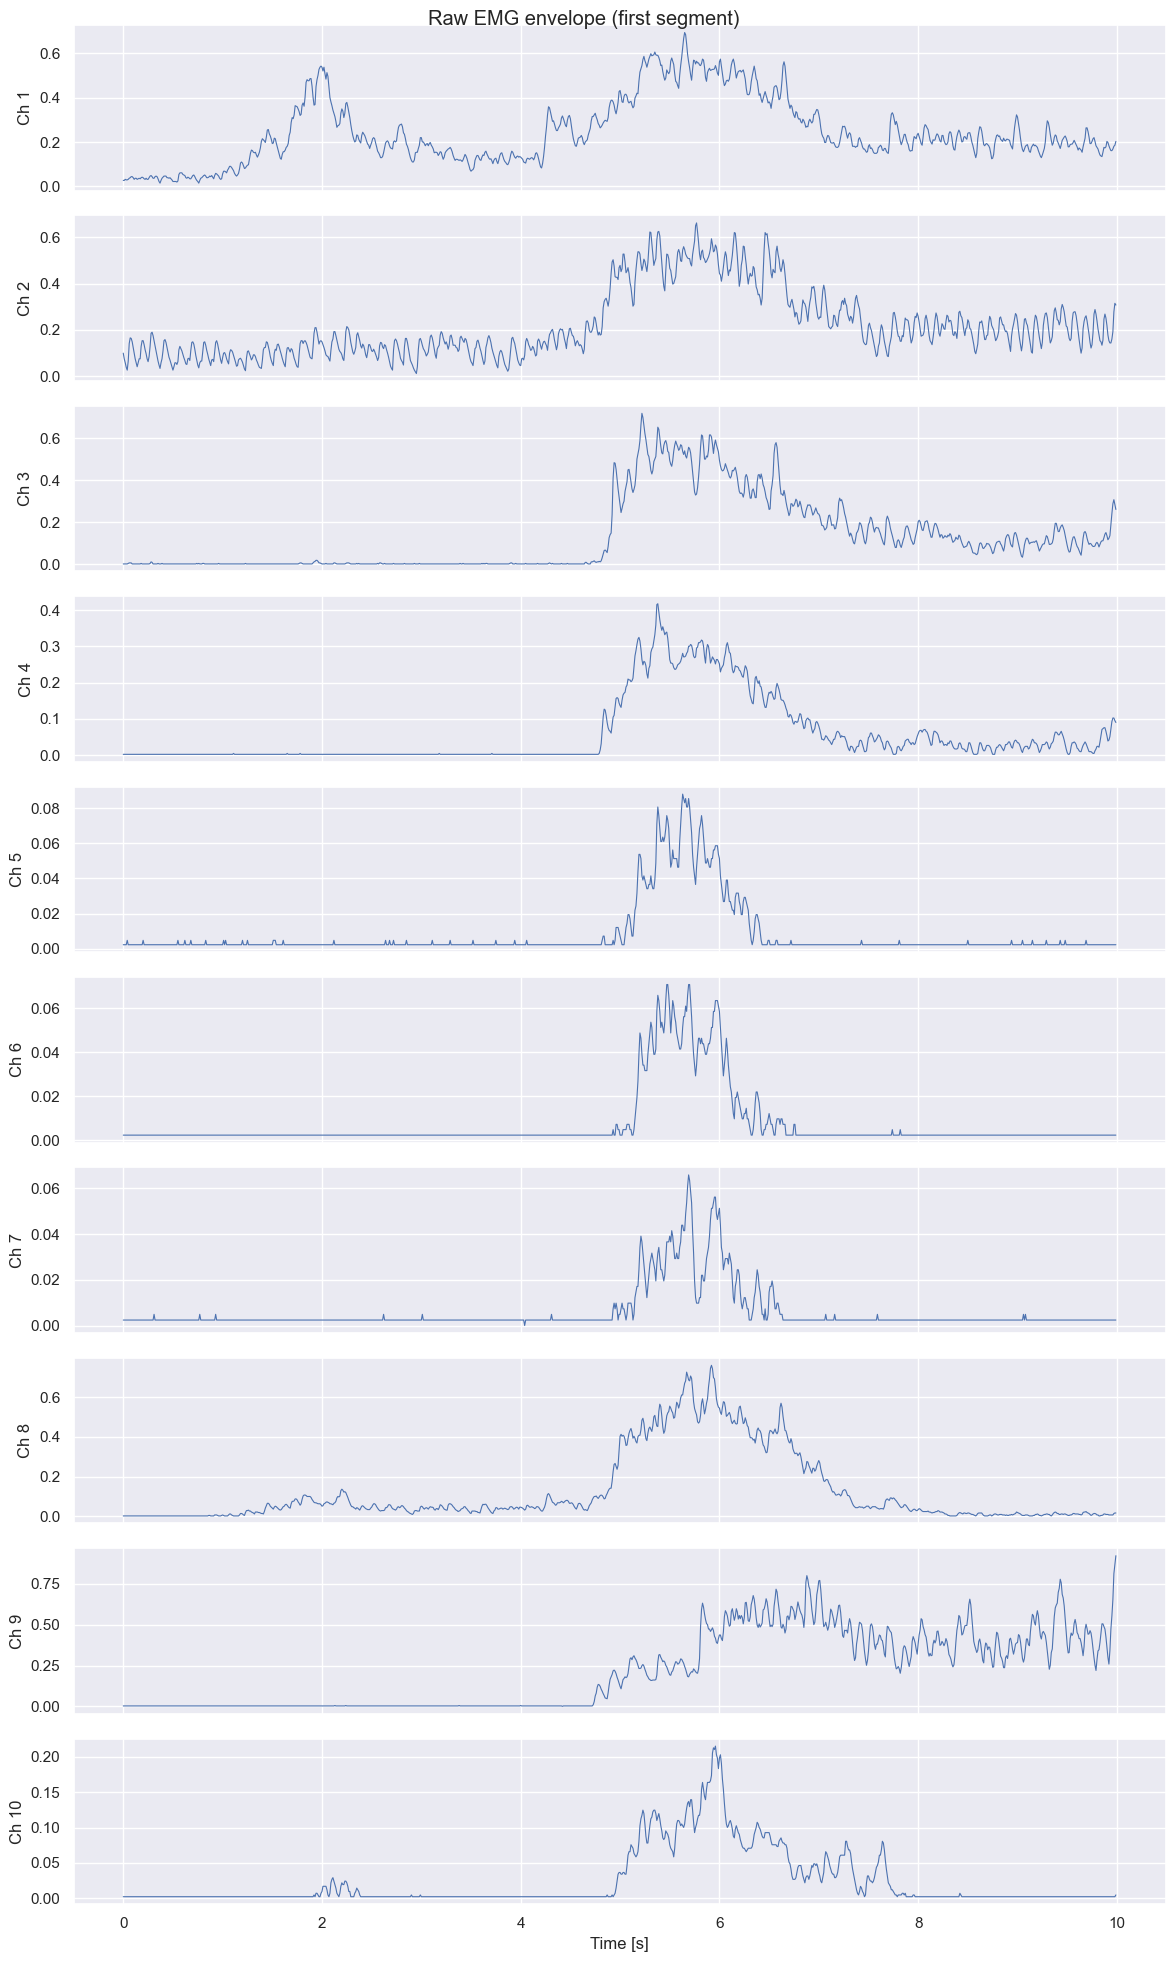

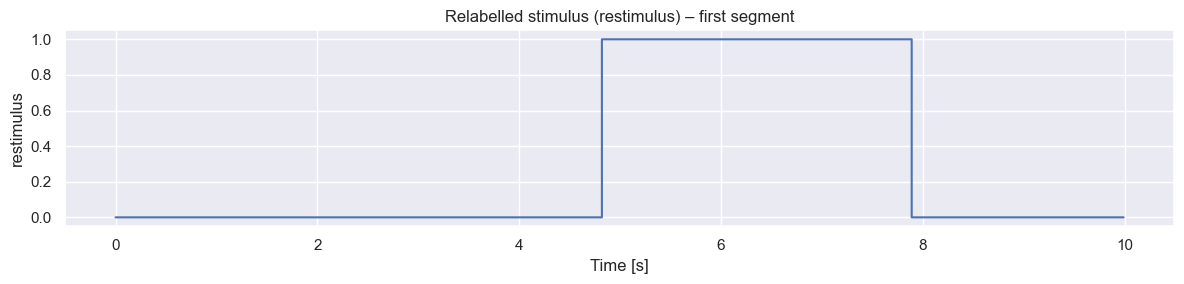

In [45]:
# Duration to visualize (in seconds)
duration_sec = 10
n_vis = min(int(duration_sec * fs), n_samples)
time_vis = np.arange(n_vis) / fs

fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2 * n_channels), sharex=True)
if n_channels == 1:
    axes = [axes]

for ch in range(n_channels):
    axes[ch].plot(time_vis, emg[:n_vis, ch], linewidth=0.8)
    axes[ch].set_ylabel(f"Ch {ch+1}")
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Raw EMG envelope (first segment)")
plt.tight_layout()
plt.show()

# Plot relabelled stimulus over the same segment
plt.figure(figsize=(12, 3))
plt.step(time_vis, restimulus[:n_vis], where="post")
plt.xlabel("Time [s]")
plt.ylabel("restimulus")
plt.title("Relabelled stimulus (restimulus) – first segment")
plt.tight_layout()
plt.show()


**Preprocessing: low-pass filtering at 5 Hz**

According to the Ninapro / TNSRE paper:

- The Otto Bock electrodes already provide an **RMS EMG envelope** (amplified, band-pass filtered and rectified).
- The authors then apply a **low-pass Butterworth filter at 5 Hz (2nd order, zero-phase)** to further smooth the envelope.

We now apply this 5 Hz low-pass filter to all EMG channels.

In [46]:
# --- Design a 5 Hz low-pass Butterworth filter (2nd order) ---
cutoff_Hz = 5.0
order = 2

sos_lp = butter(N=order,
                Wn=cutoff_Hz,
                btype="low",
                fs=fs,
                output="sos")

# Apply zero-phase filtering to all channels
emg_lp = sosfiltfilt(sos_lp, emg, axis=0)

print("Filtered EMG shape:", emg_lp.shape)

Filtered EMG shape: (100686, 10)


**Visual comparison: raw vs low-pass filtered EMG**

To verify that the filter behaves as expected, we compare the original EMG envelope and the 5 Hz low-pass filtered version on a short time window for one channel.

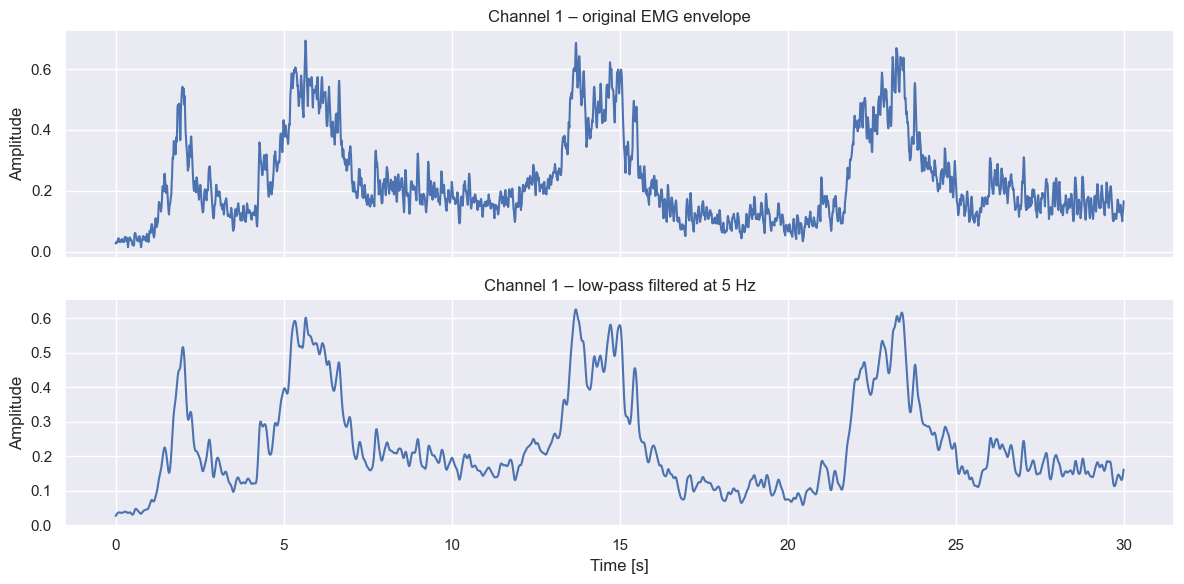

In [47]:
channel_to_plot = 0  # 0-based index
duration_sec = 30
n_vis = min(int(duration_sec * fs), n_samples)
time_vis = np.arange(n_vis) / fs

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(time_vis, emg[:n_vis, channel_to_plot])
ax[0].set_ylabel("Amplitude")
ax[0].set_title(f"Channel {channel_to_plot+1} – original EMG envelope")

ax[1].plot(time_vis, emg_lp[:n_vis, channel_to_plot])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude")
ax[1].set_title(f"Channel {channel_to_plot+1} – low-pass filtered at 5 Hz")

plt.tight_layout()
plt.show()

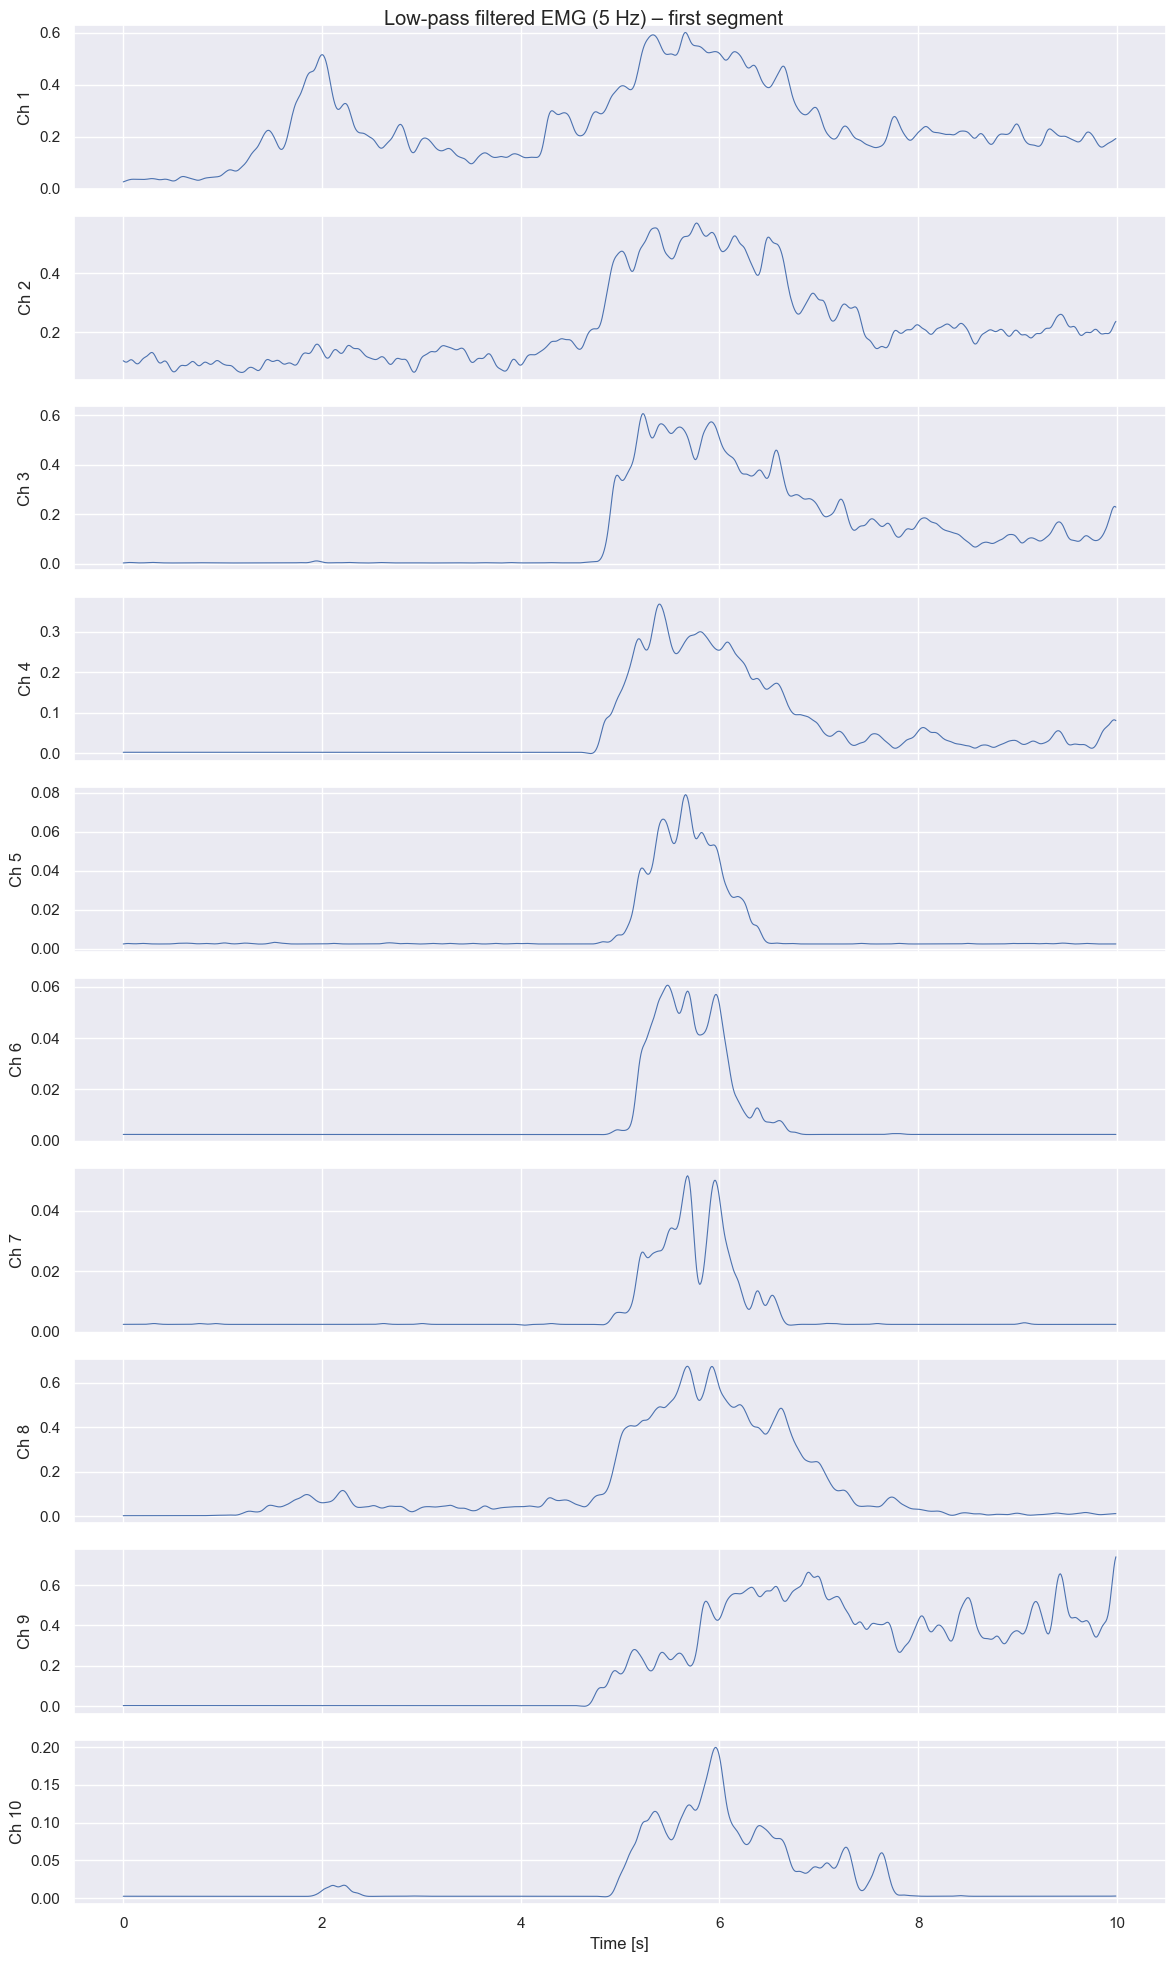

In [48]:
# We plot all channels after 5 Hz low-pass filtering (same segment as raw plot)
duration_sec = 10
n_vis = min(int(duration_sec * fs), n_samples)
time_vis = np.arange(n_vis) / fs

fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2 * n_channels), sharex=True)
if n_channels == 1:
    axes = [axes]

for ch in range(n_channels):
    axes[ch].plot(time_vis, emg_lp[:n_vis, ch], linewidth=0.8)
    axes[ch].set_ylabel(f"Ch {ch+1}")
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Low-pass filtered EMG (5 Hz) – first segment")
plt.tight_layout()
plt.show()

**Trial-wise inspection (movement × repetition)**

The relabelled variables:

- `restimulus` (movement class, including 0 = rest),
- `rerepetition` (repetition index),

define trials as segments where both values are constant.

To check whether some repetitions look abnormal (e.g. very weak activation), we compute the **mean EMG amplitude per (movement, repetition)** on the filtered signal and visualize it as a heatmap.

Number of movements (excluding rest): 12
Number of repetitions: 10


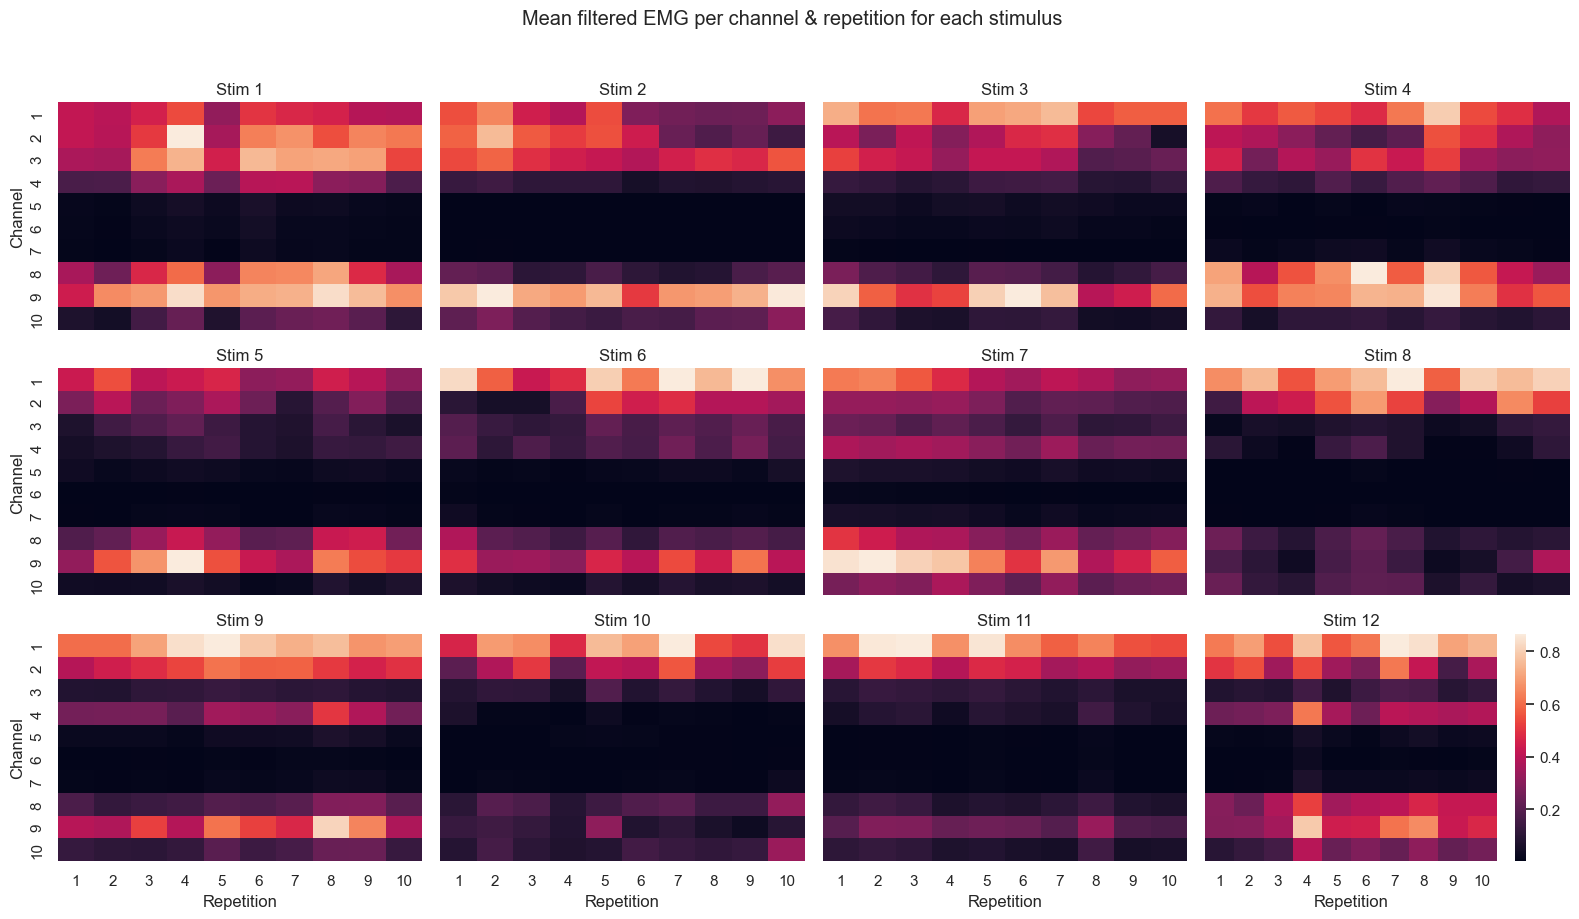

Variance of channel 1 : 0.20822645850365423
Variance of channel 2 : 0.08484612099826762
Variance of channel 3 : 0.03841790636040231
Variance of channel 4 : 0.04643012328522444
Variance of channel 5 : 0.0013161343958195606
Variance of channel 6 : 0.00017107004208903896
Variance of channel 7 : 0.0007938384938025719
Variance of channel 8 : 0.0821044956346604
Variance of channel 9 : 0.22625076462807245
Variance of channel 10 : 0.03061118281600645


In [49]:
# Unique movement labels, excluding rest (0)
unique_stimuli = np.unique(restimulus)
unique_stimuli = unique_stimuli[unique_stimuli != 0]

# Unique repetition indices, excluding 0
unique_reps = np.unique(rerepetition)
unique_reps = unique_reps[unique_reps != 0]

n_stimuli = len(unique_stimuli)
n_reps = len(unique_reps)

print("Number of movements (excluding rest):", n_stimuli)
print("Number of repetitions:", n_reps)

# Compute mean EMG amplitude per (channels, stimulus, repetition)
emg_average_activations = np.zeros((n_channels, n_stimuli, n_reps))

for i_s, s in enumerate(unique_stimuli):
    for i_r, r in enumerate(unique_reps):
        idx = (restimulus == s) & (rerepetition == r)
        if not np.any(idx):
            emg_average_activations[:, i_s, i_r] = np.nan
        else:
            emg_average_activations[:, i_s, i_r] = emg_lp[idx, :].mean(axis=0)

n_rows, n_cols = 3, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

axes = axes.flatten()  # pour indexer facilement

for i_s, s in enumerate(unique_stimuli):
    ax = axes[i_s]
    data_sr = emg_average_activations[:, i_s, :]

    sns.heatmap(
        data_sr,
        ax=ax,
        annot=False,
        xticklabels=[f"{r}" for r in unique_reps],
        yticklabels=[f"{c+1}" for c in range(n_channels)],
        cbar=(i_s == n_stimuli - 1),  
    )

    ax.set_title(f"Stim {s}")
    if i_s // n_cols == n_rows - 1:
        ax.set_xlabel("Repetition")
    else:
        ax.set_xlabel("")
    if i_s % n_cols == 0:
        ax.set_ylabel("Channel")
    else:
        ax.set_ylabel("")

for j in range(n_stimuli, n_rows * n_cols):
    axes[j].axis("off")

plt.suptitle("Mean filtered EMG per channel & repetition for each stimulus", y=1.02)
plt.tight_layout()
plt.show()

channel_var = emg_lp.var(axis=0)  # shape (n_channels,)
i=0
for elem in channel_var:
    i+=1
    print("Variance of channel", i, ":", elem)

**Conclusion for Part 1 – Question 1**

From the plots we can make the following observations:

- The EMG envelope (after 5 Hz low-pass filtering) shows clear activations for all channels during movement periods.
- The relabelled stimulus `restimulus` is consistent with the EMG activity (onsets and offsets match the bursts of activation).
- The trial-wise heatmap of mean EMG amplitude shows that:
  - all movements have non-zero activation,
  - repetitions are of comparable magnitude,
  - there are no repetitions with abnormally low or flat EMG.

**Answer to the question:**

- **Does the data look reasonable?**  
  Yes. The EMG signals for subject 2, exercise S2\_A1\_E1 look reasonable after preprocessing (5 Hz low-pass filtering), with clear activation patterns for each movement. The channel-wise variance analysis shows that channels 5, 6 and 7 have a much lower variance (≈10⁻⁴–10⁻³) than the other channels (≈3×10⁻²–2×10⁻¹), because their baseline is close to zero for most of the time. However, when looking at the time courses with channel-specific scaling, these channels still exhibit clear movement-related bursts aligned with the labels. We therefore interpret them as low-amplitude but informative channels, and we keep them for subsequent analyses.

- **Did you need to remove any trials?**  
  No. Based on the visual inspection and the trial-wise mean activation, there are no obvious corrupted or failed trials, so we keep all repetitions for this subject and exercise.


## Part1 : Question 2


In [50]:
from helpers import build_trial_index

trial_labels, trial_reps, trial_masks = build_trial_index(restimulus, rerepetition)
print("Number of trials:", len(trial_labels))  # should be 12 * 10 = 120

Number of trials: 120


**We split the data into training, validation and training**

In [51]:
from helpers import split_trials_by_repetition

TRAIN_REPS = np.array([1, 3, 4, 6, 7, 9])
VAL_REPS   = np.array([8])
TEST_REPS  = np.array([2, 5, 10])


train_trial_mask, val_trial_mask, test_trial_mask = split_trials_by_repetition(
    trial_reps, TRAIN_REPS, VAL_REPS, TEST_REPS
)

print("Train trials:", train_trial_mask.sum())
print("Val trials:  ", val_trial_mask.sum())
print("Test trials: ", test_trial_mask.sum())

Train trials: 72
Val trials:   12
Test trials:  36


For subject 2 (exercise S2_A1_E1), each of the 12 movements has 10 repetitions.
We split the data by repetitions, not by individual samples, so that all time
samples from a given repetition belong to the same subset (to avoid information
leakage between training and test sets).

We used the following split pattern for all movements:

- Training repetitions: {1, 3, 4, 6, 7, 9}  (6/10 ≈ 60%)
- Validation repetition: {8}                (1/10 ≈ 10%)
- Test repetitions: {2, 5, 10}              (3/10 ≈ 30%)

The training set is used to fit the classifier.
The validation set is used to make design choices and tune hyperparameters.
The test set is kept untouched and provides an unbiased estimate of
performance on unseen repetitions of the same movements.


## Part1 : Question 3

In [52]:
from helpers import mav, std_feature, max_av, rms, waveform_length

feature_fns = [mav, std_feature, max_av, rms, waveform_length]
feature_names = ["MAV", "STD", "MAX", "RMS", "WL"]

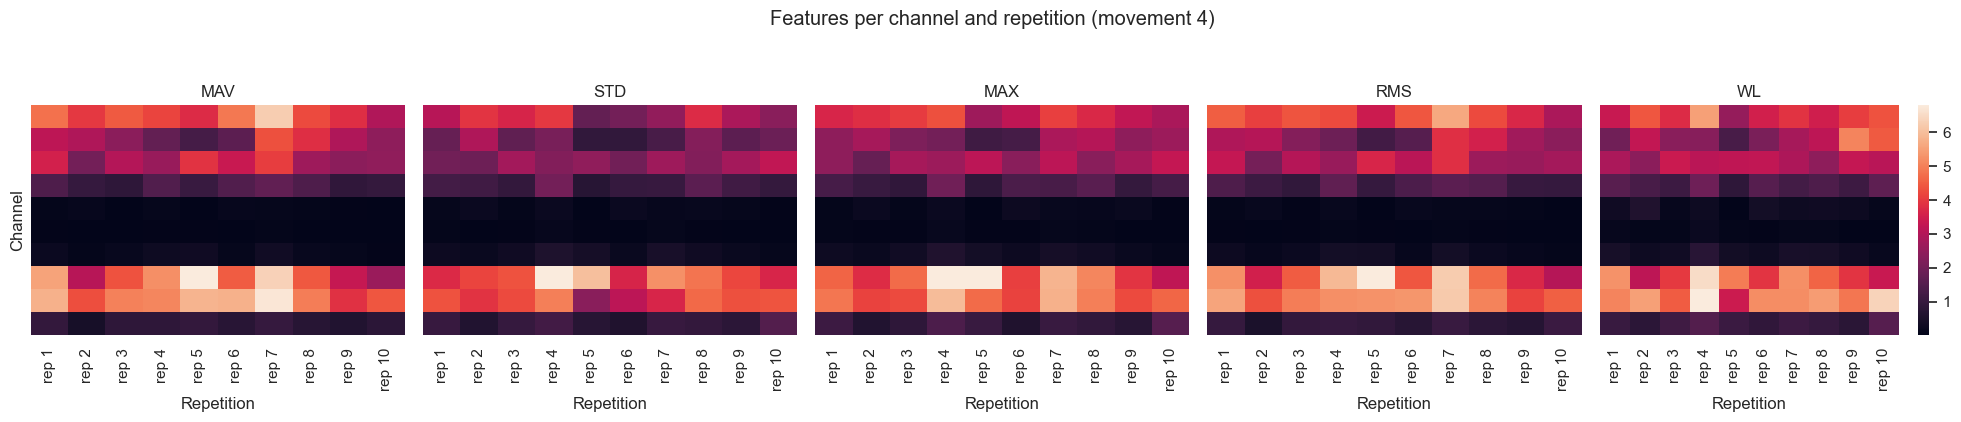

In [53]:
from helpers import build_dataset_from_ninapro_lp, get_feature_matrix_for_feature_index

X_trials, y_trials, trial_reps = build_dataset_from_ninapro_lp(
    emg_lp=emg_lp,
    stimulus=restimulus,
    repetition=rerepetition,
    features=feature_fns,
)

X_train, y_train = X_trials[train_trial_mask], y_trials[train_trial_mask]
X_val,   y_val   = X_trials[val_trial_mask],   y_trials[val_trial_mask]
X_test,  y_test  = X_trials[test_trial_mask],  y_trials[test_trial_mask]


n_feat_per_channel = len(feature_fns)
n_channels = emg_lp.shape[1]

movement_to_plot = 4  # movement we will visualize

# Mask trials for this movement
mask_movement = (y_trials == movement_to_plot)
reps_movement = trial_reps[mask_movement]

# Sort trials by repetition index for nicer plotting
order = np.argsort(reps_movement)
reps_sorted = reps_movement[order]

n_features_total = len(feature_names)
n_rows, n_cols = 1, n_features_total  # 1 row, one column per feature

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4), sharex=True, sharey=True)
if n_features_total == 1:
    axes = [axes]  # ensure iterable

for f_idx, (fname) in enumerate(feature_names):
    ax = axes[f_idx]

    # Extract (n_trials, n_channels) matrix for this feature
    feat_vals = get_feature_matrix_for_feature_index(X_trials, f_idx, n_channels)
    feat_movement = feat_vals[mask_movement, :]      # only trials for this movement
    feat_movement = feat_movement[order, :]         # sort by repetition

    sns.heatmap(
        feat_movement.T,   # channels x repetitions
        ax=ax,
        annot=False,
        xticklabels=[f"rep {r}" for r in reps_sorted],
        yticklabels=[f"ch {c+1}" for c in range(n_channels)] if f_idx == 0 else False,
        cbar=(f_idx == n_features_total - 1),  # only show colorbar on last subplot
    )

    ax.set_title(fname)
    if f_idx == 0:
        ax.set_ylabel("Channel")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Repetition")

plt.suptitle(f"Features per channel and repetition (movement {movement_to_plot})", y=1.05)
plt.tight_layout()
plt.show()


To analyse the features, we plotted MAV, STD, MAX, RMS and WL for each channel and repetition of a given movement (e.g. movement 4). All five feature maps show a very similar pattern: channels 1–3 and 8–9 systematically have higher values, while channels 5–7 remain much lower, with channels 4 and 10 in between. This is expected, since these features are all strongly related to the amplitude and overall activity of the EMG envelope. Across repetitions of the same movement, the feature values are relatively stable for each channel, indicating that the subject performs the gesture in a consistent way. Small differences between repetitions (slightly brighter or darker columns) can be explained by natural variability in muscle activation, slight changes in effort and possible fatigue. Differences between channels mainly reflect the anatomical placement and coupling of the electrodes: channels located closer to the muscles primarily involved in the movement show larger feature values, whereas channels further away (such as 5–7) capture a weaker, but still movement-related, EMG signal.

# Part 1 : Question 4

Our gorup variant is 2, we will perform a Random Forest algorithm to do the classification on the data of subject 2.

### Define ML Model 

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint, uniform
import time

In [65]:
algorithm_name = "Random Forest"
base_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 400],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (72, 50)
Validation set shape: (12, 50)
Test set shape: (36, 50)


In [ ]:
print(f"Starting hyperparameter optimization for {algorithm_name}")

# Use GridSearchCV with cross-validation on train set
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,  # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # use all CPU cores
    verbose=2
)
start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"\nOptimization completed in {end_time - start_time:.2f} seconds")
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Starting hyperparameter optimization for Random Forest

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_spli

### Evaluation on the validation set


In [68]:
best_model = grid_search.best_estimator_

# Predictions on validation set
y_val_pred = best_model.predict(X_val_scaled)
val_accuracy = np.mean(y_val_pred == y_val)
print(f"\nValidation accuracy: {val_accuracy:.4f}")

# Predictions on test set
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


Validation accuracy: 0.8333
Test accuracy: 0.8889


### Save the Model 

In [69]:
import pickle

# Save model
with open('best_model_part1.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler
with open('scaler_part1.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nModel and scaler saved successfully!")
print(f"\nFinal results for {algorithm_name}:")
print(f"  - Best params: {grid_search.best_params_}")
print(f"  - Validation accuracy: {val_accuracy:.4f}")
print(f"  - Test accuracy: {test_accuracy:.4f}")


Model and scaler saved successfully!

Final results for Random Forest:
  - Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  - Validation accuracy: 0.8333
  - Test accuracy: 0.8889


# Part 1 : Question 5

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

### Compute multiple evaluation metrics

In [85]:
# Get predictions on test set
y_test_pred = best_model.predict(X_test_scaled)

# Compute various metrics
accuracy = accuracy_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
f1_macro = f1_score(y_test, y_test_pred, average='macro')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
precision_macro = precision_score(y_test, y_test_pred, average='macro')
recall_macro = recall_score(y_test, y_test_pred, average='macro')

print("EVALUATION METRICS ON TEST SET")
print(f"\nAccuracy:                {accuracy:.4f}")
print(f"F1-Score:                {f1_macro:.4f}")
print(f"Precision:               {precision_macro:.4f}")
print(f"Recall:                  {recall_macro:.4f}")

EVALUATION METRICS ON TEST SET

Accuracy:                0.8889
F1-Score:                0.8812
Precision:               0.9181
Recall:                  0.8889


### Confusion Matrix Visualization

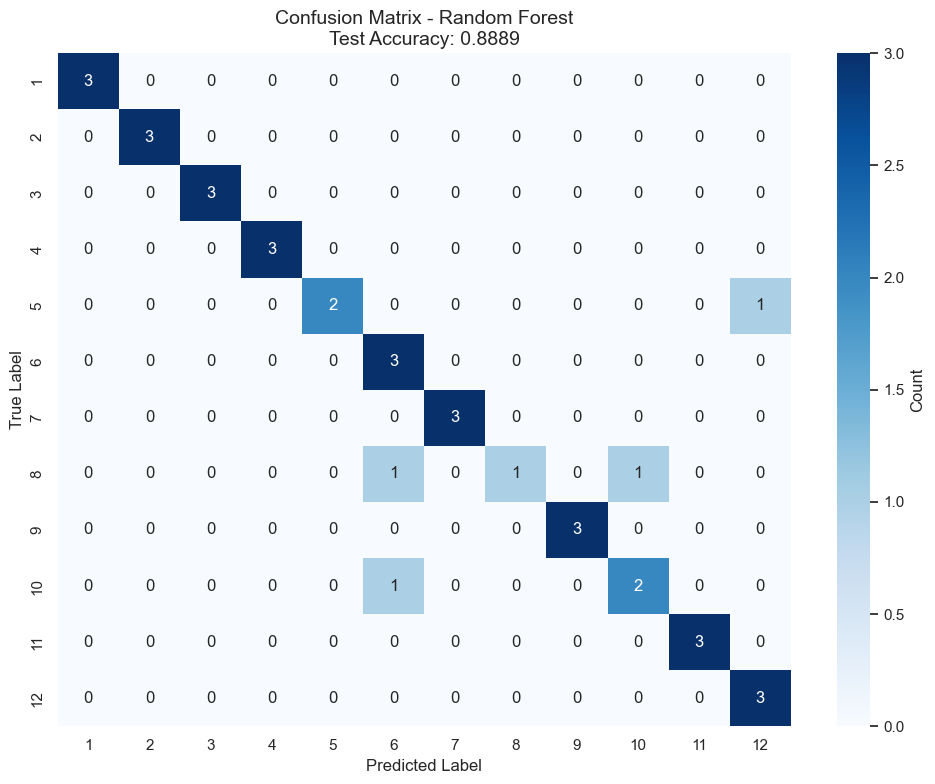

In [72]:
cm = confusion_matrix(y_test, y_test_pred)

# Get unique class labels
unique_labels = np.unique(y_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - {algorithm_name}\nTest Accuracy: {accuracy:.4f}', fontsize=14)
plt.tight_layout()
plt.show()

### Per-class performance analysis

In [ ]:
print("PER-CLASS CLASSIFICATION REPORT")
print("\n", classification_report(y_test, y_test_pred, target_names=[f"Movement {i}" for i in unique_labels]))


PER-CLASS CLASSIFICATION REPORT

               precision    recall  f1-score   support

  Movement 1       1.00      1.00      1.00         3
  Movement 2       1.00      1.00      1.00         3
  Movement 3       1.00      1.00      1.00         3
  Movement 4       1.00      1.00      1.00         3
  Movement 5       1.00      0.67      0.80         3
  Movement 6       0.60      1.00      0.75         3
  Movement 7       1.00      1.00      1.00         3
  Movement 8       1.00      0.33      0.50         3
  Movement 9       1.00      1.00      1.00         3
 Movement 10       0.67      0.67      0.67         3
 Movement 11       1.00      1.00      1.00         3
 Movement 12       0.75      1.00      0.86         3

    accuracy                           0.89        36
   macro avg       0.92      0.89      0.88        36
weighted avg       0.92      0.89      0.88        36



### Analyze per-class accuracy

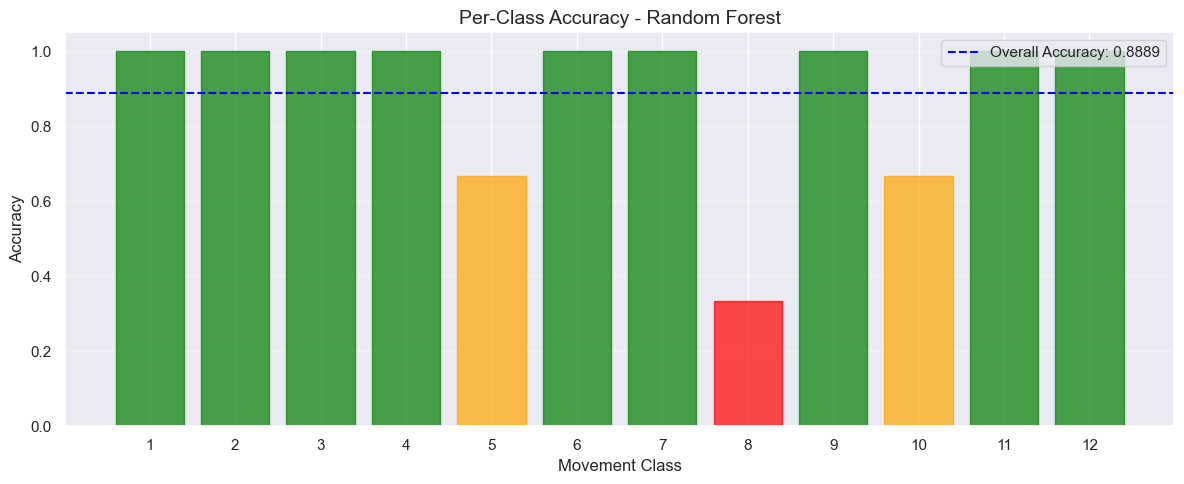

In [74]:
# Compute per-class accuracy
per_class_accuracy = []
for label in unique_labels:
    mask = (y_test == label)
    if mask.sum() > 0:
        acc = np.mean(y_test_pred[mask] == label)
        per_class_accuracy.append(acc)
    else:
        per_class_accuracy.append(0)

# Plot per-class accuracy
plt.figure(figsize=(12, 5))
bars = plt.bar(unique_labels, per_class_accuracy, alpha=0.7, edgecolor='black')

# Color bars: green if > 0.8, orange if 0.6-0.8, red if < 0.6
for i, (bar, acc) in enumerate(zip(bars, per_class_accuracy)):
    if acc >= 0.8:
        bar.set_color('green')
    elif acc >= 0.6:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.axhline(y=accuracy, color='blue', linestyle='--', label=f'Overall Accuracy: {accuracy:.4f}')
plt.xlabel('Movement Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title(f'Per-Class Accuracy - {algorithm_name}', fontsize=14)
plt.xticks(unique_labels)
plt.ylim([0, 1.05])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Justification of metric choice

In [ ]:
print("METRIC JUSTIFICATION")

print("""
WHY THESE METRICS ARE SUITABLE FOR THIS TASK:

1. ACCURACY: 
   - Simple and interpretable metric
   - Suitable because we have balanced classes (10 repetitions per movement)
   - Directly relates to the practical goal: correctly identifying movements

2. F1-SCORE (MACRO):
   - Harmonic mean of precision and recall
   - Treats all classes equally (macro averaging)
   - Good for multi-class classification problems

3. CONFUSION MATRIX:
   - Shows which movements are confused with each other
   - Helps identify systematic errors in the decoder
   - Critical for improving prosthetic control (avoid dangerous misclassifications)

PERFORMANCE ASSESSMENT:
""")

# Performance assessment
if accuracy >= 0.90:
    assessment = "EXCELLENT - The model shows very high accuracy suitable for prosthetic control"
elif accuracy >= 0.80:
    assessment = "GOOD - The model performs well, but some movements may need refinement"
elif accuracy >= 0.70:
    assessment = "ACCEPTABLE - The model shows promise but needs improvement for real-world use"
else:
    assessment = "NEEDS IMPROVEMENT - The model requires further optimization or feature engineering"

print(f"With test accuracy of {accuracy:.4f}: {assessment}")

# Check for class imbalance in predictions

print("CLASS BALANCE CHECK")


print("\nTrue class distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Movement {label}: {count} samples ({count/len(y_test)*100:.1f}%)")

print("\nPredicted class distribution:")
unique_pred, counts_pred = np.unique(y_test_pred, return_counts=True)
for label, count in zip(unique_pred, counts_pred):
    print(f"  Movement {label}: {count} predictions ({count/len(y_test_pred)*100:.1f}%)")


METRIC JUSTIFICATION

WHY THESE METRICS ARE SUITABLE FOR THIS TASK:

1. ACCURACY: 
   - Simple and interpretable metric
   - Suitable because we have balanced classes (10 repetitions per movement)
   - Directly relates to the practical goal: correctly identifying movements

2. F1-SCORE (MACRO):
   - Harmonic mean of precision and recall
   - Treats all classes equally (macro averaging)
   - Good for multi-class classification problems

3. CONFUSION MATRIX:
   - Shows which movements are confused with each other
   - Helps identify systematic errors in the decoder
   - Critical for improving prosthetic control (avoid dangerous misclassifications)

PERFORMANCE ASSESSMENT:

With test accuracy of 0.8889: GOOD - The model performs well, but some movements may need refinement

CLASS BALANCE CHECK

True class distribution:
  Movement 1: 3 samples (8.3%)
  Movement 2: 3 samples (8.3%)
  Movement 3: 3 samples (8.3%)
  Movement 4: 3 samples (8.3%)
  Movement 5: 3 samples (8.3%)
  Movement 6: 3 

# Part 1 : Question 6

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

### Method 1 : Principal Component Analysis (PCA)

METHOD 1: PRINCIPAL COMPONENT ANALYSIS (PCA)

PCA with 10 components:
  Variance explained: 0.9706
  Validation accuracy: 0.9167
  Test accuracy: 0.9167

PCA with 20 components:
  Variance explained: 0.9952
  Validation accuracy: 1.0000
  Test accuracy: 0.9167

PCA with 30 components:
  Variance explained: 0.9992
  Validation accuracy: 1.0000
  Test accuracy: 0.9444

PCA with 40 components:
  Variance explained: 1.0000
  Validation accuracy: 1.0000
  Test accuracy: 0.8611

PCA with 50 components:
  Variance explained: 1.0000
  Validation accuracy: 0.9167
  Test accuracy: 0.9444

Best number of PCA components: 30


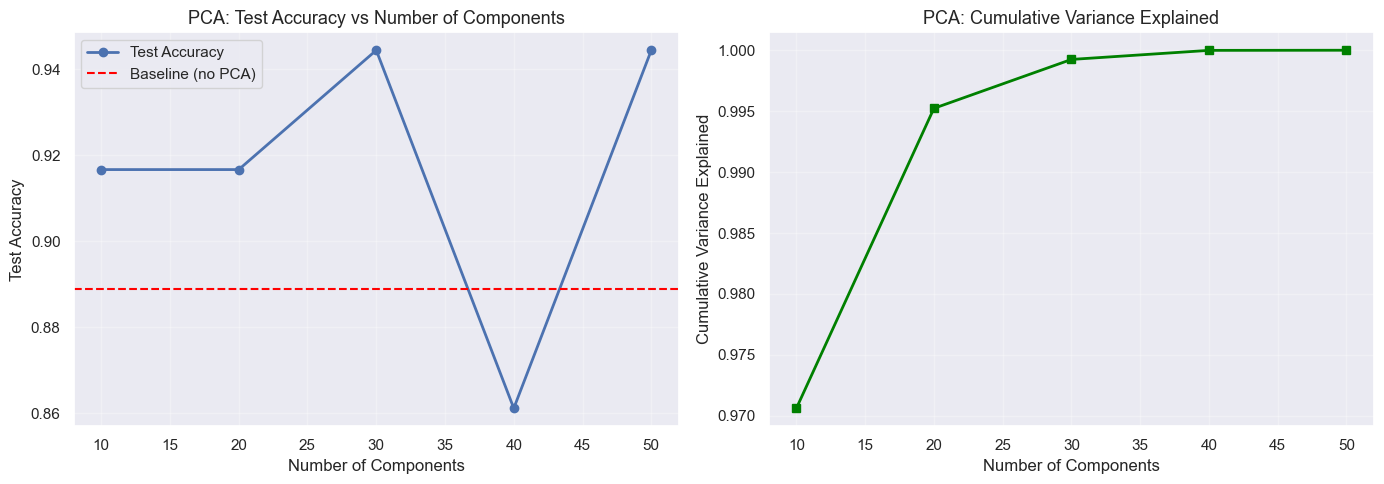

In [ ]:
print("METHOD 1: PRINCIPAL COMPONENT ANALYSIS (PCA)")

# Try different numbers of components
n_components_list = [10, 20, 30, 40, 50]
pca_results = {}

for n_comp in n_components_list:
    # Apply PCA
    pca = PCA(n_components=n_comp, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Train model on PCA-transformed features
    model_pca = type(best_model)(**best_model.get_params())
    model_pca.fit(X_train_pca, y_train)
    
    # Evaluate
    val_acc = model_pca.score(X_val_pca, y_val)
    test_acc = model_pca.score(X_test_pca, y_test)
    
    pca_results[n_comp] = {
        'val_acc': val_acc,
        'test_acc': test_acc,
        'variance_explained': pca.explained_variance_ratio_.sum()
    }
    
    print(f"\nPCA with {n_comp} components:")
    print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
    print(f"  Validation accuracy: {val_acc:.4f}")
    print(f"  Test accuracy: {test_acc:.4f}")

# Find best number of components
best_n_comp = max(pca_results.items(), key=lambda x: x[1]['test_acc'])[0]
print(f"\nBest number of PCA components: {best_n_comp}")

# Visualize PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Variance explained vs accuracy
n_comps = list(pca_results.keys())
var_explained = [pca_results[n]['variance_explained'] for n in n_comps]
test_accs = [pca_results[n]['test_acc'] for n in n_comps]

ax1 = axes[0]
ax1.plot(n_comps, test_accs, 'o-', label='Test Accuracy', linewidth=2)
ax1.axhline(y=accuracy, color='red', linestyle='--', label='Baseline (no PCA)')
ax1.set_xlabel('Number of Components', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('PCA: Test Accuracy vs Number of Components', fontsize=13)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Variance explained
ax2 = axes[1]
ax2.plot(n_comps, var_explained, 's-', color='green', linewidth=2)
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained', fontsize=12)
ax2.set_title('PCA: Cumulative Variance Explained', fontsize=13)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Apply best PCA model
pca_best = PCA(n_components=best_n_comp, random_state=42)
X_train_pca_best = pca_best.fit_transform(X_train_scaled)
X_test_pca_best = pca_best.transform(X_test_scaled)

model_pca_best = type(best_model)(**best_model.get_params())
model_pca_best.fit(X_train_pca_best, y_train)
test_acc_pca = model_pca_best.score(X_test_pca_best, y_test)

### Method 2: Feature Selection based on Statistical Tests


METHOD 2: UNIVARIATE FEATURE SELECTION (SelectKBest)

SelectKBest with k=10 features:
  Validation accuracy: 0.8333
  Test accuracy: 0.8611

SelectKBest with k=20 features:
  Validation accuracy: 0.8333
  Test accuracy: 0.8333

SelectKBest with k=30 features:
  Validation accuracy: 0.8333
  Test accuracy: 0.8889

SelectKBest with k=40 features:
  Validation accuracy: 0.8333
  Test accuracy: 0.9167

SelectKBest with k=50 features:
  Validation accuracy: 0.8333
  Test accuracy: 0.8889

Best number of features: 40


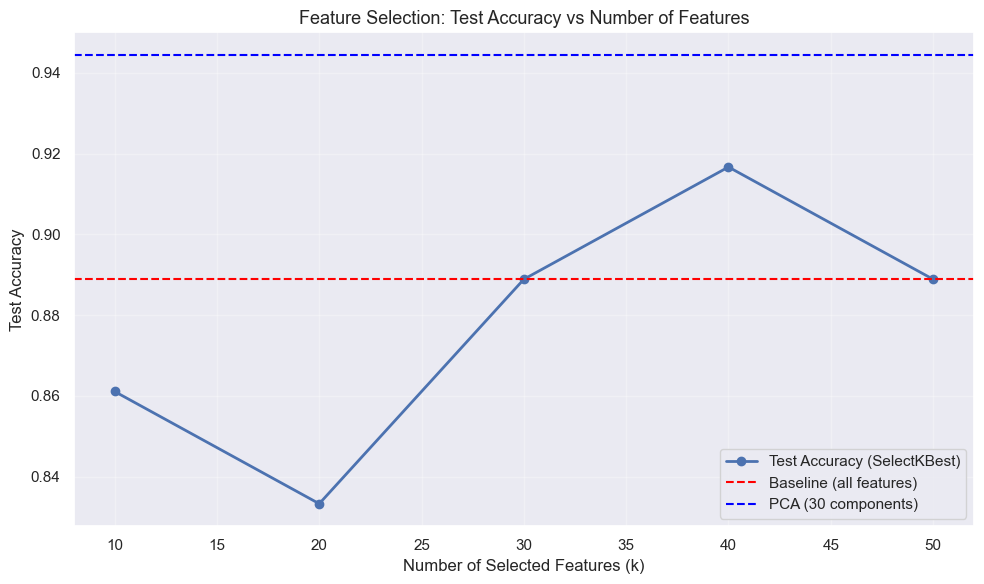

In [ ]:
print("METHOD 2: UNIVARIATE FEATURE SELECTION (SelectKBest)")

# Try different numbers of features
k_features_list = [10, 20, 30, 40, 50]
selectk_results = {}

for k in k_features_list:
    # Apply SelectKBest with ANOVA F-test
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_val_selected = selector.transform(X_val_scaled)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Train model on selected features
    model_selected = type(best_model)(**best_model.get_params())
    model_selected.fit(X_train_selected, y_train)
    
    # Evaluate
    val_acc = model_selected.score(X_val_selected, y_val)
    test_acc = model_selected.score(X_test_selected, y_test)
    
    selectk_results[k] = {
        'val_acc': val_acc,
        'test_acc': test_acc,
        'selected_features': selector.get_support()
    }
    
    print(f"\nSelectKBest with k={k} features:")
    print(f"  Validation accuracy: {val_acc:.4f}")
    print(f"  Test accuracy: {test_acc:.4f}")

# Find best k
best_k = max(selectk_results.items(), key=lambda x: x[1]['test_acc'])[0]
print(f"\nBest number of features: {best_k}")

# Visualize SelectKBest results
plt.figure(figsize=(10, 6))
k_vals = list(selectk_results.keys())
test_accs_k = [selectk_results[k]['test_acc'] for k in k_vals]

plt.plot(k_vals, test_accs_k, 'o-', linewidth=2, label='Test Accuracy (SelectKBest)')
plt.axhline(y=accuracy, color='red', linestyle='--', label='Baseline (all features)')
plt.axhline(y=test_acc_pca, color='blue', linestyle='--', label=f'PCA ({best_n_comp} components)')
plt.xlabel('Number of Selected Features (k)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Feature Selection: Test Accuracy vs Number of Features', fontsize=13)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Apply best feature selection
selector_best = SelectKBest(score_func=f_classif, k=best_k)
X_train_selected_best = selector_best.fit_transform(X_train_scaled, y_train)
X_test_selected_best = selector_best.transform(X_test_scaled)

model_selected_best = type(best_model)(**best_model.get_params())
model_selected_best.fit(X_train_selected_best, y_train)
test_acc_selected = model_selected_best.score(X_test_selected_best, y_test)

### Visualize wich features were selected 

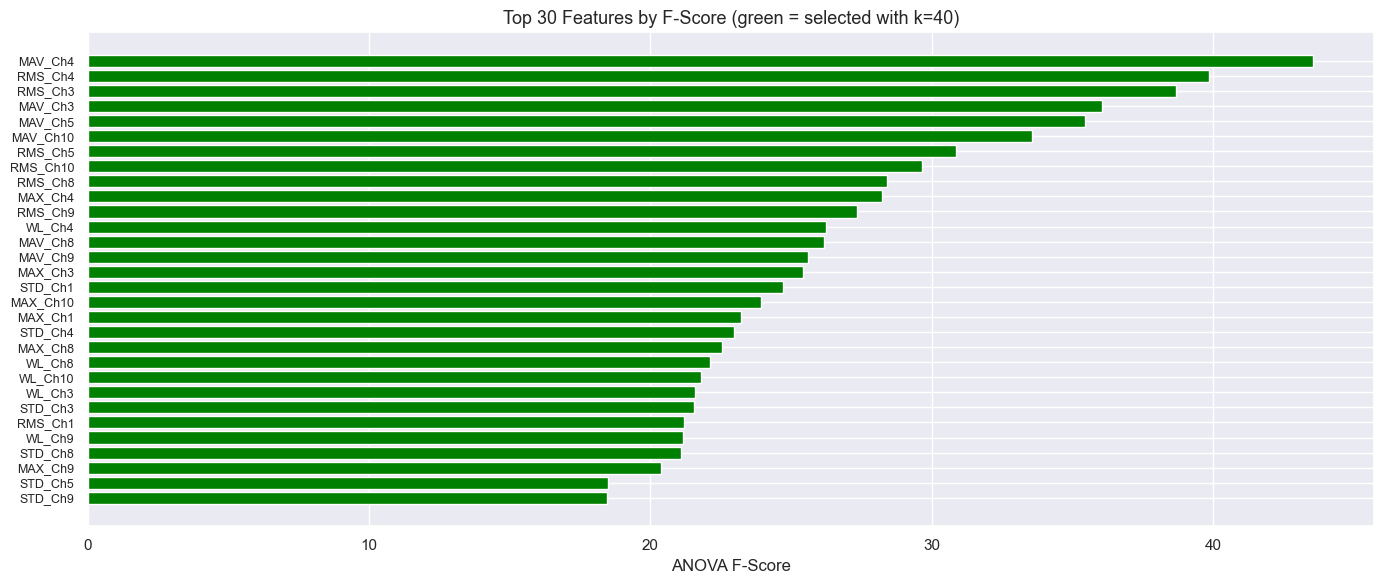

In [83]:
# Get feature importance scores
scores = selector_best.scores_
selected_mask = selector_best.get_support()

# Map features to (feature_type, channel)
n_channels = emg_lp.shape[1]
feature_names_full = []
for feat_name in feature_names:
    for ch in range(1, n_channels + 1):
        feature_names_full.append(f"{feat_name}_Ch{ch}")

# Create visualization
plt.figure(figsize=(14, 6))

# Sort by score
sorted_idx = np.argsort(scores)[::-1]
top_30_idx = sorted_idx[:30]

colors = ['green' if selected_mask[i] else 'gray' for i in top_30_idx]
plt.barh(range(30), scores[top_30_idx], color=colors)
plt.yticks(range(30), [feature_names_full[i] for i in top_30_idx], fontsize=9)
plt.xlabel('ANOVA F-Score', fontsize=12)
plt.title(f'Top 30 Features by F-Score (green = selected with k={best_k})', fontsize=13)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### COMPARISON


FINAL COMPARISON

Test Accuracy Comparison:
  Baseline (all features): 0.8889 (+0.00%)
  PCA (30 components): 0.9444 (+5.56%)
  SelectKBest (k=40): 0.9167 (+2.78%)


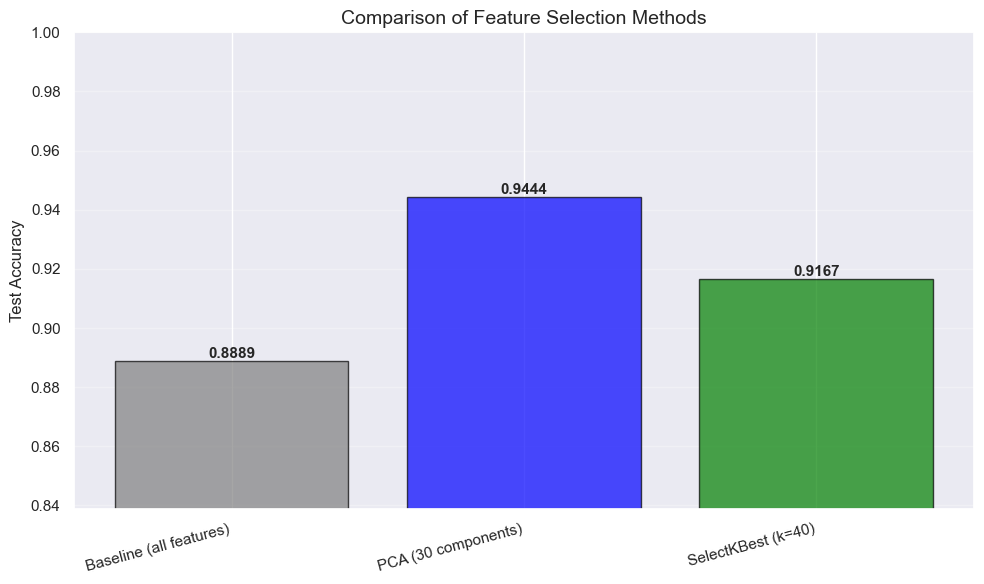


ANALYSIS AND INTERPRETATION

INTERPRETATION OF RESULTS:

1. PCA (Dimensionality Reduction):
   - Reduces computational complexity
   - Removes noise and redundancy
   - Creates orthogonal components
   - May lose some discriminative information

2. SelectKBest (Feature Selection):
   - Keeps original feature interpretability
   - Selects most discriminative features
   - Removes redundant or noisy features
   - Better for understanding which EMG characteristics matter most

WHY PERFORMANCE CHANGED:

✓ PCA IMPROVED performance by 5.56%
  → Likely due to noise reduction and removing redundant features
✓ Feature Selection IMPROVED performance by 2.78%
  → Removed noisy/irrelevant features while keeping discriminative ones

→ BEST METHOD: PCA (30 components) with accuracy 0.9444


In [ ]:
print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)

results_comparison = {
    'Baseline (all features)': accuracy,
    f'PCA ({best_n_comp} components)': test_acc_pca,
    f'SelectKBest (k={best_k})': test_acc_selected
}

print("\nTest Accuracy Comparison:")
for method, acc in results_comparison.items():
    improvement = (acc - accuracy) * 100
    print(f"  {method}: {acc:.4f} ({improvement:+.2f}%)")

# Bar plot comparison
plt.figure(figsize=(10, 6))
methods = list(results_comparison.keys())
accuracies = list(results_comparison.values())
colors_bar = ['gray', 'blue', 'green']

bars = plt.bar(methods, accuracies, color=colors_bar, alpha=0.7, edgecolor='black')
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Comparison of Feature Selection Methods', fontsize=14)
plt.ylim([min(accuracies) - 0.05, 1.0])
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("ANALYSIS AND INTERPRETATION")

print("""
INTERPRETATION OF RESULTS:

1. PCA (Dimensionality Reduction):
   - Reduces computational complexity
   - Removes noise and redundancy
   - Creates orthogonal components
   - May lose some discriminative information
   
2. SelectKBest (Feature Selection):
   - Keeps original feature interpretability
   - Selects most discriminative features
   - Removes redundant or noisy features
   - Better for understanding which EMG characteristics matter most

WHY PERFORMANCE CHANGED:
""")

if test_acc_pca > accuracy:
    print(f"✓ PCA IMPROVED performance by {(test_acc_pca - accuracy)*100:.2f}%")
    print("  → Likely due to noise reduction and removing redundant features")
else:
    print(f"✗ PCA DECREASED performance by {(accuracy - test_acc_pca)*100:.2f}%")
    print("  → May have lost important discriminative information")

if test_acc_selected > accuracy:
    print(f"✓ Feature Selection IMPROVED performance by {(test_acc_selected - accuracy)*100:.2f}%")
    print("  → Removed noisy/irrelevant features while keeping discriminative ones")
else:
    print(f"✗ Feature Selection DECREASED performance by {(accuracy - test_acc_selected)*100:.2f}%")
    print("  → May need more features or different selection criterion")

best_method = max(results_comparison.items(), key=lambda x: x[1])
print(f"\n→ BEST METHOD: {best_method[0]} with accuracy {best_method[1]:.4f}")